# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)

# data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
# data.shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   138  100   138    0     0    147      0 --:--:-- --:--:-- --:--:--   147
100    17  100    17    0     0      9      0  0:00:01  0:00:01 --:--:--   377
100   475    0   475    0     0    138      0 --:--:--  0:00:03 --:--:--     0
100  119M  100  119M    0     0  7627k      0  0:00:16  0:00:16 --:--:-- 10.1M
Train_rev1.csv


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

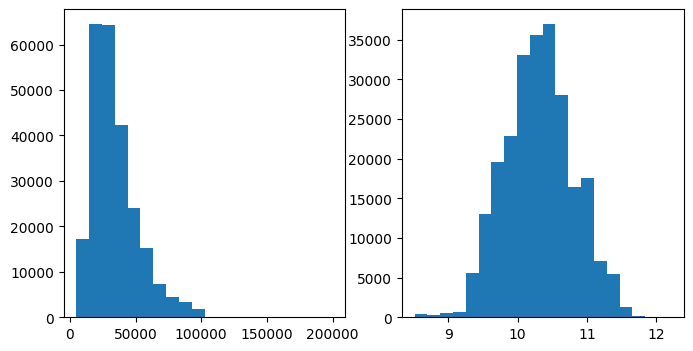

In [124]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [125]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

Id                                                        Title  \
63610   68704550                                         inventory supervisor   
111185  69683978  senior it systems engineer fast growing it support business   
191939  71752805                     labourers with confined space experience   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [126]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                mathematical modeller / simulation analyst / operational analyst basingstoke , hampshire up to **** k aae pension contribution , private medical and dental the opportunity our client is an independent consultancy firm which has an opportunity for a data analyst with 35 years experience . the role wil

In [127]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
data["Title"] = data["Title"].astype(str)
data["FullDescription"] = data["FullDescription"].astype(str)

data["Title"] = [" ".join(tokenizer.tokenize(text.lower())) for text in data["Title"]]
data["FullDescription"] = [" ".join(tokenizer.tokenize(text.lower())) for text in data["FullDescription"]]

Now we can assume that our text is a space-separated list of tokens:

In [7]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [128]:
from collections import Counter
token_counts = Counter()

def count_words(data_coll):
    for text in data_coll.values:
        for word in text.split():
            token_counts[word] += 1

count_words(data["FullDescription"])
count_words(data["Title"])

In [129]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


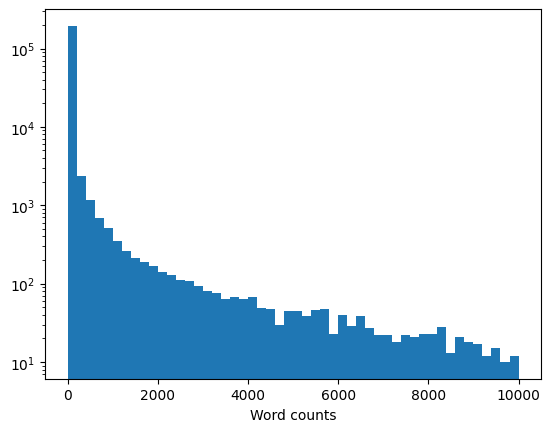

In [130]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=(0, 10**4), bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [131]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count > min_count]

In [132]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(30000, 40000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 32456
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [133]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [134]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [135]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [136]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10273 28655  2055     1     1]
 [14296  2700     1     1     1]
 [26272  9698    14 14484 10270]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [137]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [138]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [139]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [140]:
make_batch(data_train[:3], max_len=10)

{'Title': array([[26272, 28401, 31999,     1,     1,     1,     1],
        [27772,   187, 18227, 19056, 14801, 22008,  3848],
        [10082, 28895, 16876,    31,  8281, 27695,    61]], dtype=int32),
 'FullDescription': array([[26272, 28401, 31999, 31307,   909, 26272, 28401, 31999, 15662,
         31307],
        [27772,   187, 18227, 19056, 14801, 22008,  3848, 24230,   836,
            77],
        [29212, 20872, 19591,  6092, 15662,  7773, 26125,   909, 28895,
         16876]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [141]:
import keras
import keras.layers as L

In [142]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    emb = L.Embedding(n_tokens, 16)
    
    descr_emb = emb(l_descr)
    descr_conv = L.Conv1D(32, kernel_size=4, padding="same", name="descr_conv")(descr_emb)
    descr_features = L.GlobalMaxPool1D()(descr_conv)
    
    title_emb = emb(l_title)
    title_conv = L.Conv1D(24, kernel_size=2, padding="same", name="title_conv")(title_emb)
    title_features = L.GlobalMaxPool1D()(title_conv)
    
    joint = L.concatenate([title_features, descr_features, l_categ])
    
    hid = L.Dense(hid_size)(joint)
    
    output_layer = L.Dense(1)(hid)
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [143]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Title (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FullDescription     │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 16)  │    519,296 │ FullDescription[… │
│ (Embedding)         │                   │            │ Title[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_conv (Conv1D) │ (None, None, 24)  │        792 │ embedding_3[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ descr_conv (Conv1D) │ (None, None, 32)  │      2,080 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 24)        │          0 │ title_conv[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ descr_conv[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Categorical         │ (None, 3767)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 3823)      │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ Categorical[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │    244,736 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 766,969 (2.93 MB)

 Trainable params: 766,969 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [144]:
print("Data length:", len(tokens))
print("N categorical features:", len(categorical_vectorizer.vocabulary_))

Data length: 32456
N categorical features: 3767


#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [145]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [146]:
batch_size = 256
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - loss: 39.7156 - mean_absolute_error: 4.8626 - val_loss: 0.3448 - val_mean_absolute_error: 0.4542
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - loss: 0.2643 - mean_absolute_error: 0.3987 - val_loss: 0.3029 - val_mean_absolute_error: 0.4254
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - loss: 0.1980 - mean_absolute_error: 0.3364 - val_loss: 0.2274 - val_mean_absolute_error: 0.3608
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - loss: 0.1676 - mean_absolute_error: 0.3030 - val_loss: 0.2270 - val_mean_absolute_error: 0.3654
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 0.1429 - mean_absolute_error: 0.2818 - val_loss: 0.1899 - val_mean_absolute_error: 0.3300
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 0.1378 - mean_absolute_error: 0.2754 - val_loss: 0.1703 - val_mean_absolute_error: 0.3119
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - loss: 0.1269 - mean_abso

In [147]:
from tqdm import tqdm


def print_metrics(model: keras.models.Model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in tqdm(iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)):
        batch_pred = model.predict(batch_x, verbose=0)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

765it [02:06,  6.06it/s]


Train results:
Mean square error: 0.12295
Mean absolute error: 0.26333


192it [00:41,  4.61it/s]

Val results:
Mean square error: 0.12740
Mean absolute error: 0.26939


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [29]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token), verbose=0)[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [30]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [31]:
tokens_and_weights = [
    ("test", -10),
    ("title", 10),
    ("word", 0)
]
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

test title word

In [32]:
def explain_test_sample(data_sample):
    tokens_and_weights = explain(model, data_sample, "Title")
    draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;')
    
    tokens_and_weights = explain(model, data_sample, "FullDescription")
    draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights])

In [33]:
test_sample = data.loc[0].copy()

test_sample["Title"] = "senior python developer"
test_sample["FullDescription"] = "highly skilled python developer with 5 years of experience"
explain_test_sample(test_sample)

senior python developer

highly skilled python developer with 5 years of experience

In [35]:
test_sample["Title"] = "trainee python intern / part time"
test_sample["FullDescription"] = "low skilled python enthusiast"
explain_test_sample(test_sample)

trainee python intern / part time

low skilled python enthusiast

In [36]:
test_sample["Title"] = "head of python development"
test_sample["FullDescription"] = "manager of python developers"
explain_test_sample(test_sample)

head of python development

manager of python developers

In [37]:
test_sample["Title"] = "cleaning assistant"
test_sample["FullDescription"] = "simple job for students cleaning assistant"
explain_test_sample(test_sample)

cleaning assistant

simple job for students cleaning assistant

In [38]:
test_sample["Title"] = "accounts assistant"
test_sample["FullDescription"] = "assistant in the accounts department / finance / accounts assistant"
explain_test_sample(test_sample)

accounts assistant

assistant in the accounts department / finance / accounts assistant

In [39]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [40]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [118]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;')

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 220214
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Salary (gbp): 13401.17


sql server bi analyst developer , ssis , ssrs / reports insurance

sql server bi analyst developer , ssis , ssrs / reports insurance , london **** k **** k bonus sql server analyst developer ( bi , ssis , ssrs / reports ) is needed for one of the world ' s leading insurance companies , based in the prestigious lloyds of london insurance building in the city of london . working in an experienced development team you will be developing reports ( ssrs ) using bi , sql server , ssis , ssas , olap cube , etl , access and other reporting tools . this company are soon to be migrating onto sql server 2012 , in which you will be trained on and using . this is an excellent opportunity for a sql server bi analyst developer ( ssis , ssrs / reports ) to join a company that offers excellent career prospects and the opportunities for professional certifications and training . you roles and responsibilities within this company will progress onto various different tasks and you will be heavily involved in projects . sql server bi analyst developer , ssis , ssrs / reports skills in sql server ( queries etc .) must have exposure to reporting tools must have ssis experience must have etl , data warehousing , ssas , olap beneficial ssrs or other reporting tools e . g . crystal reports beneficial please apply for more information or call dan brown at harrington starr recruitment . sql server , bi analyst , reports developer , etl , ssrs , ssis , data warehousing , olap cube , crystal reports sql server bi analyst developer , ssis , ssrs / reports insurance , london **** k **** k bonus this job was originally posted as www . cwjobs . co . uk / jobseeking / UNK ****

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)